In [39]:
import random
import cadquery as cq
import numpy as np
import pyvista as pv
import numpy as np
from math import pi, sqrt, pow, acos, degrees, radians, sin, cos
from data import helper_temp as helper
from copy import deepcopy
import miniball
import pymeshfix as mf
from decimal import *
from scipy.stats import qmc
import math
import matplotlib.pyplot as plt
import itertools
import pandas as pd

# Create parameter list

In [2]:
# define parameter ranges 
c_min, c_max = 10, 100
a_c_ratio_min, a_c_ratio_max = 0.1, 1
f_r0_min, f_r0_max = 0.75, 1
f_hp_min, f_hp_max = 0.75, 1.25
f_h0_min, f_h0_max = 0.75, 1.25

In [3]:
# generate LHS
sampler = qmc.LatinHypercube(d = 5, optimization='random-cd')
samples = sampler.random(n=20)
samples[:5]

array([[0.5643672 , 0.85222185, 0.33653537, 0.77583683, 0.98387163],
       [0.98296982, 0.09408548, 0.40754494, 0.56626991, 0.42878691],
       [0.39487363, 0.81613137, 0.05485321, 0.06227931, 0.48239025],
       [0.79151858, 0.54444911, 0.39517144, 0.17846909, 0.12433599],
       [0.40951134, 0.26244142, 0.1151996 , 0.83465609, 0.08009927]])

In [4]:
# metric for quality of the samples
qmc.discrepancy(samples) 

0.011798712843271332

In [5]:
# scale samples to bounds
l_bounds = [c_min, a_c_ratio_min, f_r0_min, f_hp_min, f_h0_min]
u_bounds = [c_max, a_c_ratio_max, f_r0_max, f_hp_max, f_h0_max]
param_list = qmc.scale(samples, l_bounds, u_bounds)
param_list[:5]

array([[60.79304822,  0.86699967,  0.83413384,  1.13791842,  1.24193581],
       [98.4672835 ,  0.18467693,  0.85188624,  1.03313495,  0.96439345],
       [45.53862683,  0.83451823,  0.7637133 ,  0.78113966,  0.99119512],
       [81.23667177,  0.59000419,  0.84879286,  0.83923455,  0.812168  ],
       [46.85602047,  0.33619728,  0.7787999 ,  1.16732805,  0.79004963]])

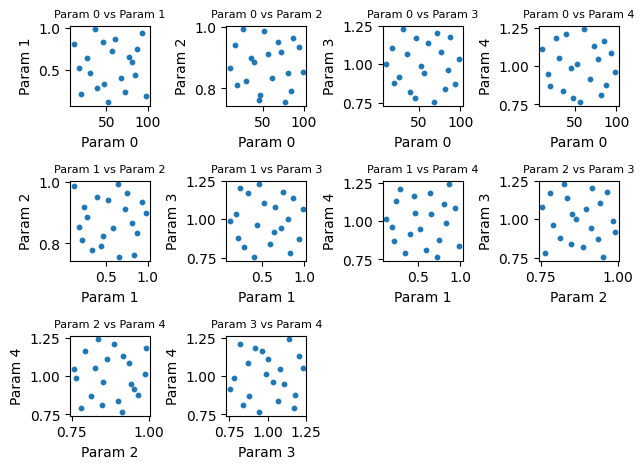

In [33]:
# plot 2-d cross sections of parameter space to visually inspect

# Calculate the ideal number of rows and columns
total_subplots = len(list(itertools.combinations(range(param_list.shape[1]), 2)))
ncols = math.ceil(math.sqrt(total_subplots))
nrows = math.ceil(total_subplots / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
axes = axes.flatten()

# Plot each unique combination of columns
for i, (x_idx, y_idx) in enumerate(itertools.combinations(range(param_list.shape[1]), 2)):
    ax = axes[i]
    ax.scatter(param_list[:, x_idx], param_list[:, y_idx], s=10)
    ax.set_xlabel(f'Param {x_idx}')
    ax.set_ylabel(f'Param {y_idx}')
    ax.set_title(f'Param {x_idx} vs Param {y_idx}', fontsize=8)
    ax.set_box_aspect(1)
    # ax.set_aspect('equal', adjustable='datalim')  # Set aspect ratio to be equal

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.subplots_adjust(wspace=0.5, hspace=0.0)
plt.show()

param_list columns:
- col1 = c   
- col2 = a_c_ratio  
- col3 = f_r0   
- col4 = f_hp   
- col5 = f_h0  

In [38]:
# generate final parameter list, including diagnosed parameters
bullet_params = []
for i in range(len(param_list)):
    param = param_list[i]
    c = param[0]
    a = c*param[1]
    r0 = param[2]*a
    hp = r0*param[3]
    h0 = (hp/4)*param[4]
    record = [a, c, r0, hp, h0]
    bullet_params.append(record)

In [40]:
# convert to dataframe for easy reading and save as csv
colnames = ['a', 'c', 'r0', 'hp', 'h0']
df_bullet_params = pd.DataFrame(bullet_params, columns=colnames)

# save dataframe to csv
# df_bullet_params.to_csv('bullet_params.csv', index=False)

In [41]:
df_bullet_params

,a,c,r0,hp,h0
0,52.707553,60.793048,43.965153,50.028758,15.533126
1,18.184636,98.467284,15.491241,16.004542,3.858669
2,38.002814,45.538627,29.023255,22.671215,5.617900
3,47.929977,81.236672,40.682622,34.142262,6.932313
4,15.752866,46.856020,12.268331,14.321167,2.828608
5,41.077414,56.428191,37.459742,35.339964,6.762750
6,17.328284,72.366313,15.896310,19.165605,5.426044
7,50.731732,77.282805,38.337513,41.392284,10.844009
8,65.336327,87.260464,62.973505,74.025914,16.198276
9,14.037760,30.314101,11.574479,14.195353,3.740377
